# Lethal Roads, V2
------------

## Introduction

### Overview

A little while ago, I did blog posts on:

* Fatal Road Crash Locations

* Australian 1Km Population Grid

Just for fun, I decided the combine both datasets.  You would expect there to be more fatal crashs where there are more people.  I wanted to take population density into account to find out Queensland's most dangerous roads

--------------
## Implementation

### Notebook magic commands

In [146]:
%matplotlib inline

In [147]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [148]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### Notebook imports

In [149]:
# all imports should go here

import pandas as pd
import sys
import os
import subprocess
import datetime
import platform
import datetime

import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import (
    LONGITUDE_FORMATTER,
    LATITUDE_FORMATTER,
)
from cartopy.io import shapereader

from osgeo import gdal, osr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

import numpy as np
import math

import geopandas as gpd

----------------------
## Map Projections

### Introduction

To recap, we can't use my standard PlateCarree map projection, because in dealing with population density, we want an Equal-Area projection.  The Australian Bureau of Statistics (ABS) used ```Albers_Conic_Equal_Area``` for their data grid.

To show the difference, I plot the world in Plate Carree, then get the ABS TGeoTIFF file, extract and print the projection details, and plot the world in _that_ projection.

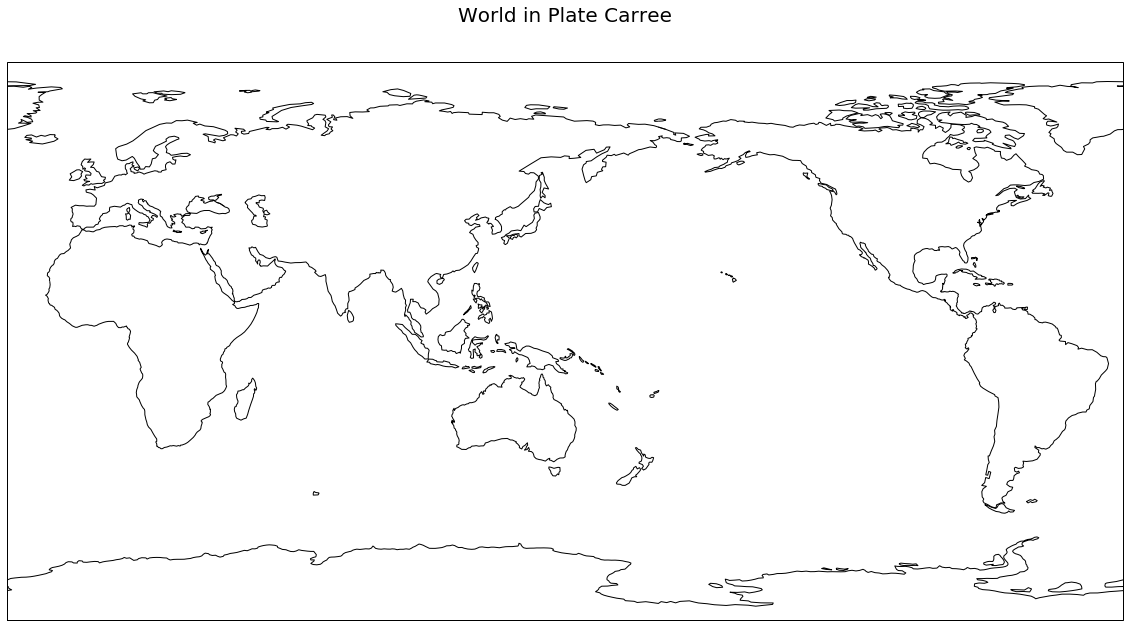

In [150]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(
    1,
    1,
    1,
    projection=ccrs.PlateCarree(central_longitude=150),
)

ax.set_global()
ax.coastlines()


plt.title('World in Plate Carree', {'fontsize': 20}, pad=40)
plt.show()

---
### Read Dataset

Read the ABS Population Density dataset, extract and display projection details

In [151]:
pop = gdal.Open(
    'd:\\qml\\Australian_Population_Grid_2011.tif'
)
data = pop.ReadAsArray()
gt = pop.GetGeoTransform()
proj = pop.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print("[ RASTER BAND COUNT ]: ", pop.RasterCount)
cols = pop.RasterXSize
print('cols = ', cols)
rows = pop.RasterYSize
print(' rows = ', rows)
bands = pop.RasterCount
print('bands = ', bands)
driver = pop.GetDriver().LongName
print('driver =', driver)

print('MetaData = ', pop.GetMetadata())

print(inproj)

[ RASTER BAND COUNT ]:  1
cols =  6382
 rows =  3821
bands =  1
driver = GeoTIFF
MetaData =  {'AREA_OR_POINT': 'Area', 'DataType': 'Generic'}
PROJCS["GDA_1994_Albers",
    GEOGCS["GCS_GDA_1994",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS_1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6283"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["standard_parallel_1",-18],
    PARAMETER["standard_parallel_2",-36],
    PARAMETER["latitude_of_center",0],
    PARAMETER["longitude_of_center",132],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


In [152]:
proj_wkt = pop.GetProjection()
print(proj_wkt)

PROJCS["GDA_1994_Albers",GEOGCS["GCS_GDA_1994",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS_1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [153]:
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)
print(proj)

PROJCS["GDA_1994_Albers",
    GEOGCS["GCS_GDA_1994",
        DATUM["Geocentric_Datum_of_Australia_1994",
            SPHEROID["GRS_1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6283"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["standard_parallel_1",-18],
    PARAMETER["standard_parallel_2",-36],
    PARAMETER["latitude_of_center",0],
    PARAMETER["longitude_of_center",132],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


In [154]:
extent_tif = (
    gt[0],
    gt[0] + pop.RasterXSize * gt[1],
    gt[3] + pop.RasterYSize * gt[5],
    gt[3],
)

print(pop.RasterXSize, pop.RasterYSize, extent_tif)

6382 3821 (-3853000.0, 2529000.0, -4835000.0, -1014000.0)


---
### Create Geospatial Environment

Create a ```Cartopy``` projection that matches the ABS projection

In [155]:
albo = ccrs.AlbersEqualArea(
    central_latitude=0,
    false_easting=0,
    false_northing=0,
    central_longitude=132,
    standard_parallels=(-18, -36),
)

-----
### Plot example map

Plot the world in our chosen projection

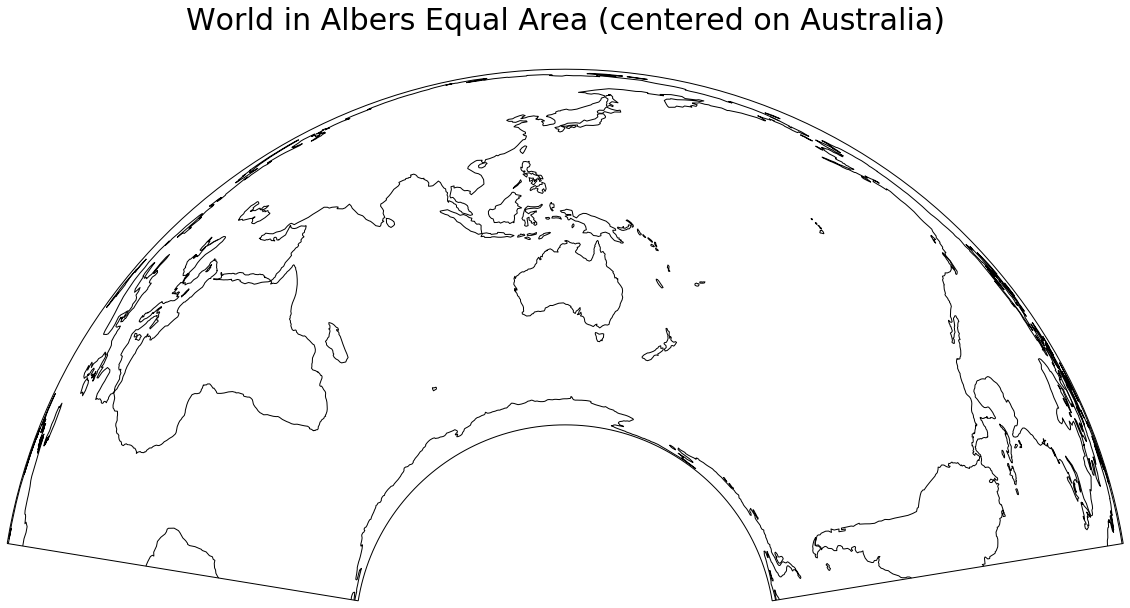

In [156]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=albo)

ax.set_global()
ax.coastlines()

# plt.imshow(data, extent=extent_tif, transform=albo)
plt.title(
    'World in Albers Equal Area (centered on Australia)',
    {'fontsize': 30},
    pad=40,
)

plt.show()

---
## Population Density

We start by plotting at the 1Km grid resolution

### Helper Functions
Define a function to draw the Queensland map background for our data, to be constant across different visualizations

In [157]:
def draw_queensland(projection=None):
    '''
    draw_queensland:  draw a map of Queensland in the nominated projection
    
    Parameters:
    projection: Cartopy ccrs, defaults to None
    
    Returns:
    (Figure object, Axes object) tuple
    
    Notes:
    Extent of QLD hardcoded to include some of neighbouring states for context
    
    Size of map hard coded to be 20, 20
    
    We draw coastlines, lat/lon gridlines, and state borders
    
    The coastlines are fairly coarse, but are not the main focus of the map, so OK
    '''
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    ax.set_extent(
        (137.4, 154.2, -30, -9.8), crs=ccrs.PlateCarree()
    )

    ax.coastlines(color='black', zorder=5)

    # draw lat lon grid
    ax.gridlines()

    # Create a feature for States/Admin 1 regions at 1:10m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none',
    )

    # plot state border
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    ax.add_feature(
        states_provinces, edgecolor='gray', zorder=5
    )

    return fig, ax


# end draw_queensland

----
### Plot the Population Density

This map is largely a failure, because most of the population density is located inside a few pixels.  Queensland (and Australia) is a big empty place!

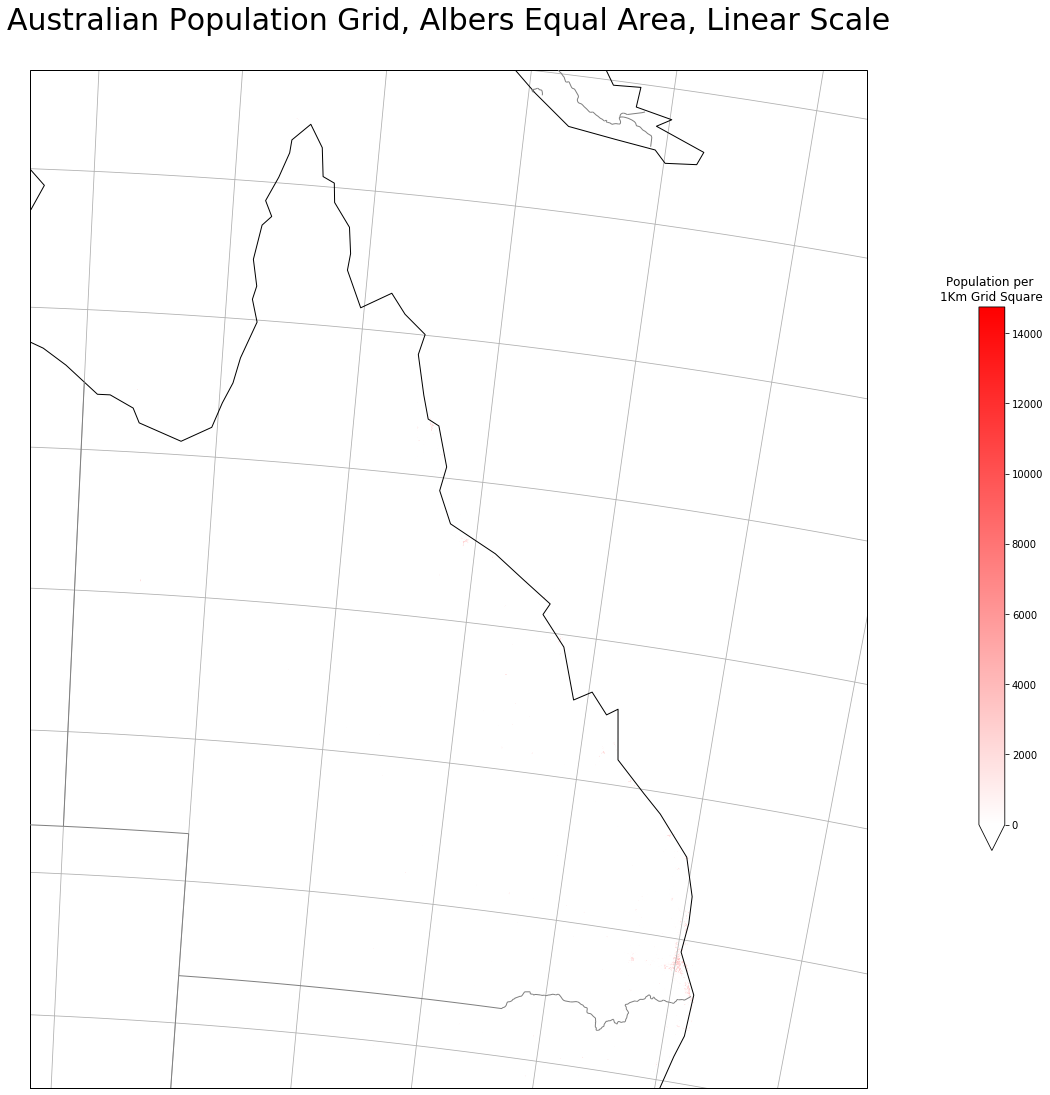

In [158]:
fig, ax = draw_queensland(projection=albo)

mycmap = colors.LinearSegmentedColormap.from_list(
    'mycmap', ['white', 'red']
)

pcm = plt.imshow(
    data,
    extent=extent_tif,
    transform=albo,
    cmap=mycmap,
    zorder=1,
    alpha=1,
)

cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)
cbar.ax.set_title('Population per \n1Km Grid Square')


plt.title(
    'Australian Population Grid, Albers Equal Area, Linear Scale',
    {'fontsize': 30},
    pad=40,
)


plt.show()

----
### Log Scales
Using a Log scale for the population density helps a little  (brings out the low population density areas better)

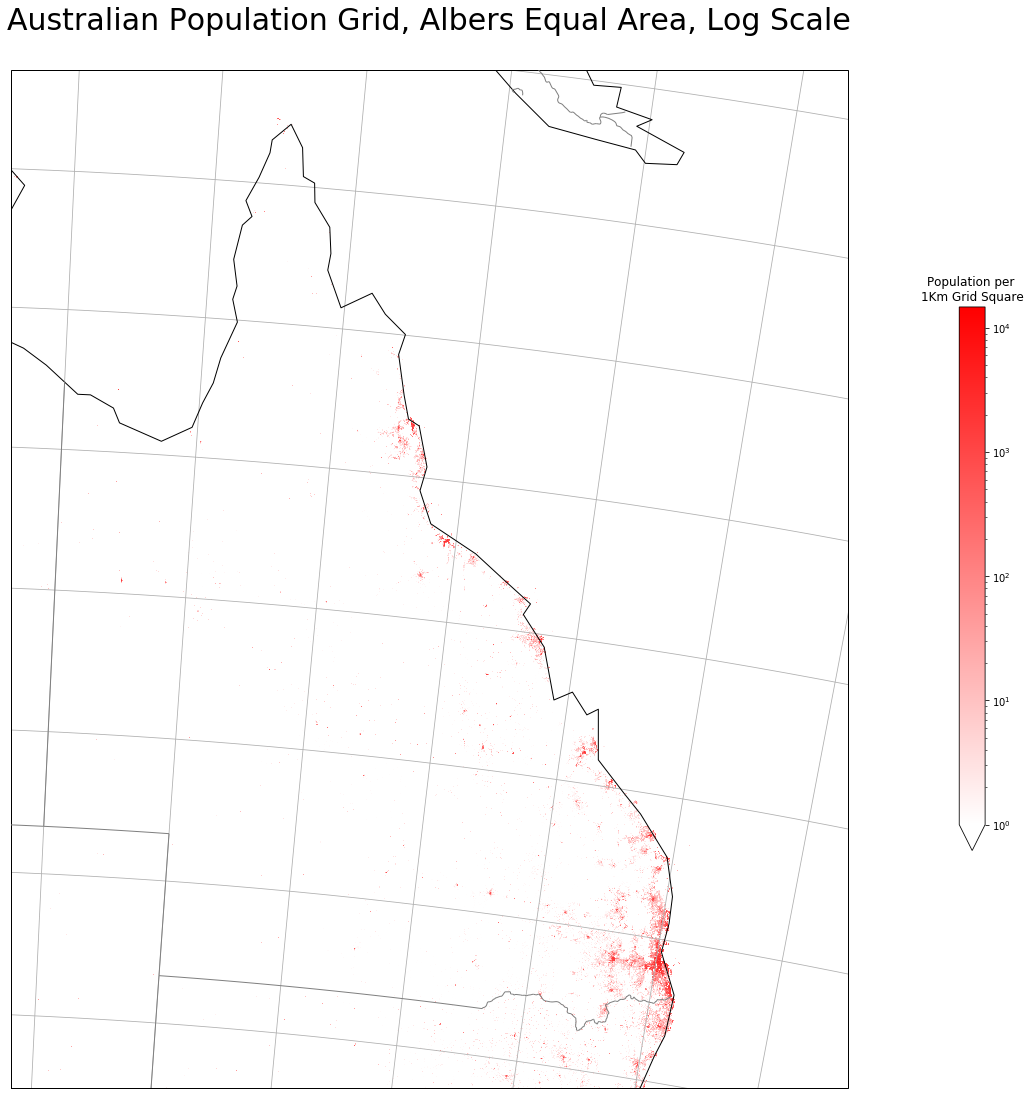

In [159]:
fig, ax = draw_queensland(projection=albo)


mycmap = colors.LinearSegmentedColormap.from_list(
    'mycmap', ['white', 'red']
)

pcm = plt.imshow(
    data,
    extent=extent_tif,
    transform=albo,
    cmap=mycmap,
    norm=colors.LogNorm(
        vmin=data.min() + 1, vmax=data.max()
    ),
    zorder=1,
    alpha=1,
)

cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)
cbar.ax.set_title('Population per \n1Km Grid Square')


plt.title(
    'Australian Population Grid, Albers Equal Area, Log Scale',
    {'fontsize': 30},
    pad=40,
)


plt.show()

-----
## Data Aggregation

We can get a better visualization (for our purposes) by aggregation to give a 100 Km grid

In [160]:
data.shape

(3821, 6382)

In [161]:
data[0:3800, 0:6300].shape

(3800, 6300)

```pandas``` magic to collapse a big array into a smaller one

In [162]:
def shrink(data, rows, cols):
    '''
    shrink: reduce an array by aggregating in x and y dimensions to give an array of the specified size
    
    Parameters:
    data: input numpy array
    rows: number of rows in resized and aggregated array
    cols: number of columns in resized and aggregated array
    
    Returns:
    Resized array
    
    Example:
    a = np.array(
    [
        [1, 2, 3, 4, 5, 6],
        [5, 6, 7, 8, 7, 8],
        [9, 10, 11, 12, 13, 14],
        [13, 14, 15, 16, 17, 18],
    ]
            )

    shrink(a, 2, 3)

    array([[14, 22, 26],
           [46, 54, 62]])
    
    
    '''
    return (
        data.reshape(
            rows,
            data.shape[0] // rows,
            cols,
            data.shape[1] // cols,
        )
        .sum(axis=1)
        .sum(axis=2)
    )


# end if

----
Collapse our fine grid

In [163]:
# collapse 1km grid to 100 km grid

data2 = data[0:3800, 0:6300]
data3 = shrink(data2, 38, 63)

----
Plot our coarse grid.  We can see the population hugging the coast, and the big mining towns inland

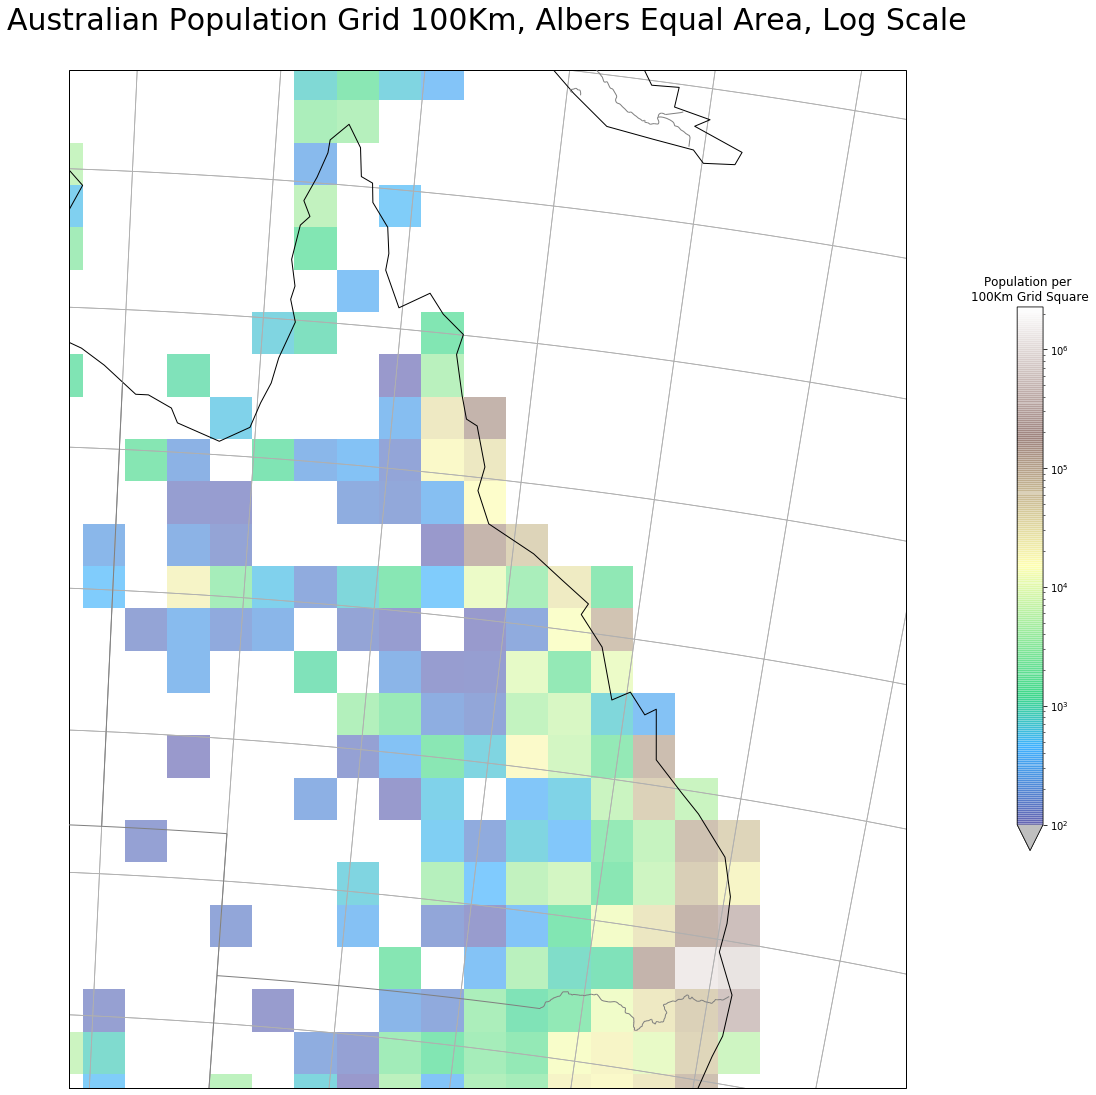

In [164]:
fig, ax = draw_queensland(projection=albo)

my_cmap = plt.cm.get_cmap('terrain')
my_cmap.set_under('grey', alpha=0.0)

# because we are truncating the data array to show, we must recompute the
# map extent it covers
down_scale_factor = 1

# original x and y step (we know it is = 1km, but get value from GEOTIF object for generality)
x_step = gt[1]
y_step = gt[5]

data3_ext = [
    extent_tif[0],
    extent_tif[0]
    + x_step
    * data[0:3800, 0:6300].shape[1]
    * down_scale_factor,
    extent_tif[3]
    + (y_step)
    * data[0:3800, 0:6300].shape[0]
    * down_scale_factor,
    extent_tif[3],
]

pcm = plt.imshow(
    data3,
    extent=data3_ext,
    transform=albo,
    cmap=my_cmap,
    norm=colors.LogNorm(),
    zorder=1,
    alpha=0.5,
    vmin=100,
)

cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)
cbar.ax.set_title('Population per \n100Km Grid Square')

# draw lat lon grid
ax.gridlines()

plt.title(
    'Australian Population Grid 100Km, Albers Equal Area, Log Scale',
    {'fontsize': 30},
    pad=40,
)

plt.show()

----------
### Medium Grid

We can also do the same for a 10 Km grid

In [165]:
# collapse 1km grid to 10 km grid

data2 = data[0:3800, 0:6300]
data4 = shrink(data2, 380, 630)

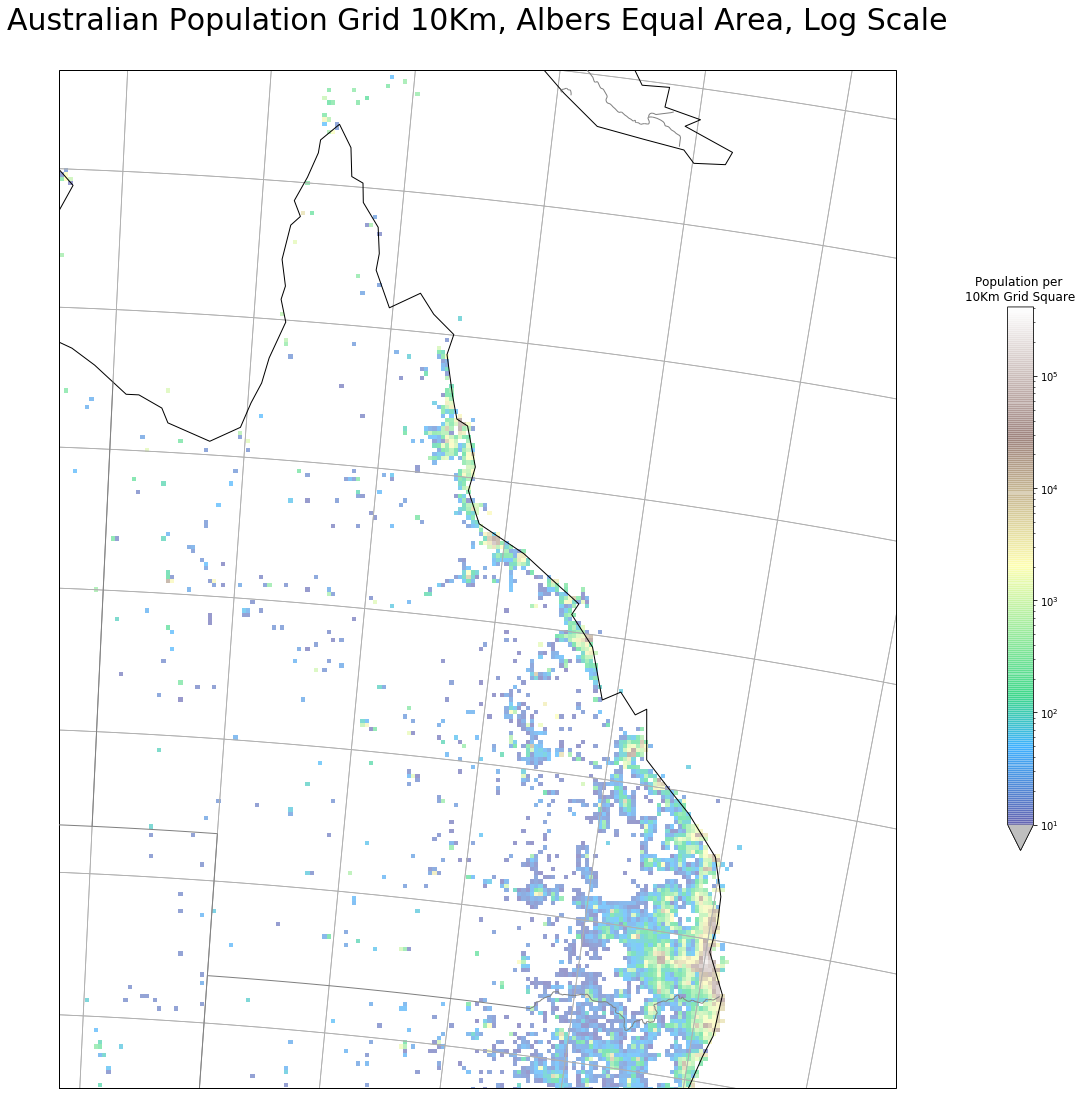

In [166]:
fig, ax = draw_queensland(projection=albo)

my_cmap = plt.cm.get_cmap('terrain')
my_cmap.set_under('grey', alpha=0.0)

# because we are truncating the data array to show, we must recompute the
# map extent it covers
down_scale_factor = 10

# original x and y step (we know it is = 1km, but get value from GEOTIF object for generality)
x_step = gt[1]
y_step = gt[5]

data4_ext = [
    extent_tif[0],
    extent_tif[0]
    + x_step * data4.shape[1] * down_scale_factor,
    extent_tif[3]
    + (y_step) * data4.shape[0] * down_scale_factor,
    extent_tif[3],
]

pcm = plt.imshow(
    data4,
    extent=data4_ext,
    transform=albo,
    cmap=my_cmap,
    norm=colors.LogNorm(),
    zorder=1,
    alpha=0.5,
    vmin=10,
)

cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)
cbar.ax.set_title('Population per \n10Km Grid Square')

# draw lat lon grid
ax.gridlines()

plt.title(
    'Australian Population Grid 10Km, Albers Equal Area, Log Scale',
    {'fontsize': 30},
    pad=40,
)

plt.show()

-----
## Fatal Crash Locations

So now we have our population grids sorted, we will use the coarse grid to look at the relation between population density, and fatal crash rate 

### Read Crash Location Dataset

In [167]:
crash_path = 'D:\\QLDCrashLocations\\data\\locations.csv'
crashes = pd.read_csv(
    crash_path, dtype={'Loc_Post_Code': str}
)

In [168]:
fatal = crashes[crashes["Crash_Severity"] == 'Fatal']

In [169]:
fatal.head(1)

,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude_GDA94,Crash_Latitude_GDA94,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
18,19,Fatal,2001,January,Thursday,9,Hit pedestrian,Hit pedestrian,151.934354,-27.566384,...,0,0,1,0,0,1,0,0,1,0


---
### Transform Crash Location Coordinates

We transform then  crash location lat/lon coordinates into the Albers Equal Area coordinate system

In [170]:
albo_xy = albo.transform_points(
    ccrs.PlateCarree(),
    np.array(fatal['Crash_Longitude_GDA94']),
    np.array(fatal['Crash_Latitude_GDA94']),
)

In [171]:
albo_xy.shape

(4761, 3)

### Map the Fatal Crash Locations

Because of the coarse coastlines we chose to use, we don't draw the off-shore islands, so there seem to be crashes at sea (not dataset defects).

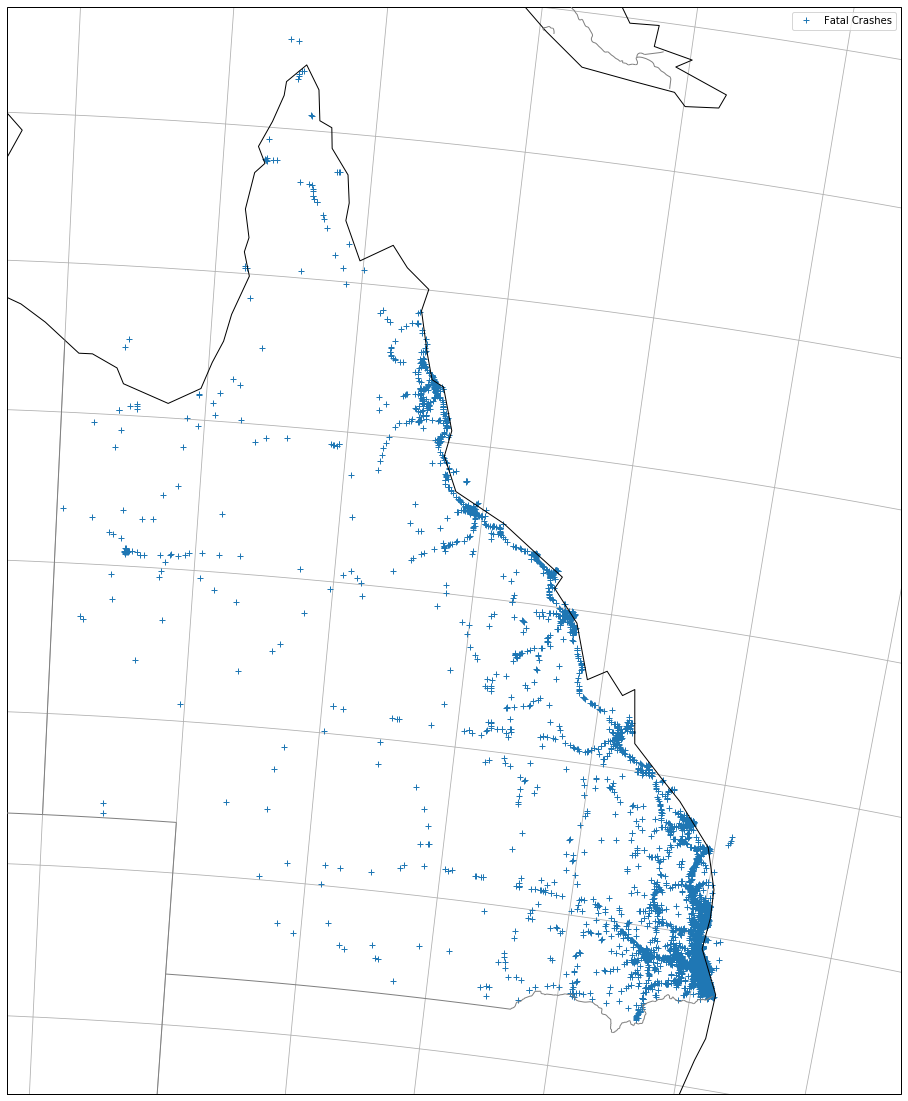

In [172]:
fig, ax = draw_queensland(projection=albo)

ax.plot(
    albo_xy[:, 0], albo_xy[:, 1], '+', label='Fatal Crashes'
)


ax.legend()

plt.show()

----
## Combined Visualization

We combine the visualization of the two datasets.  Note we have a colorbar __and__ a legend

Subjectively, we can see more crashes in areas of high population density

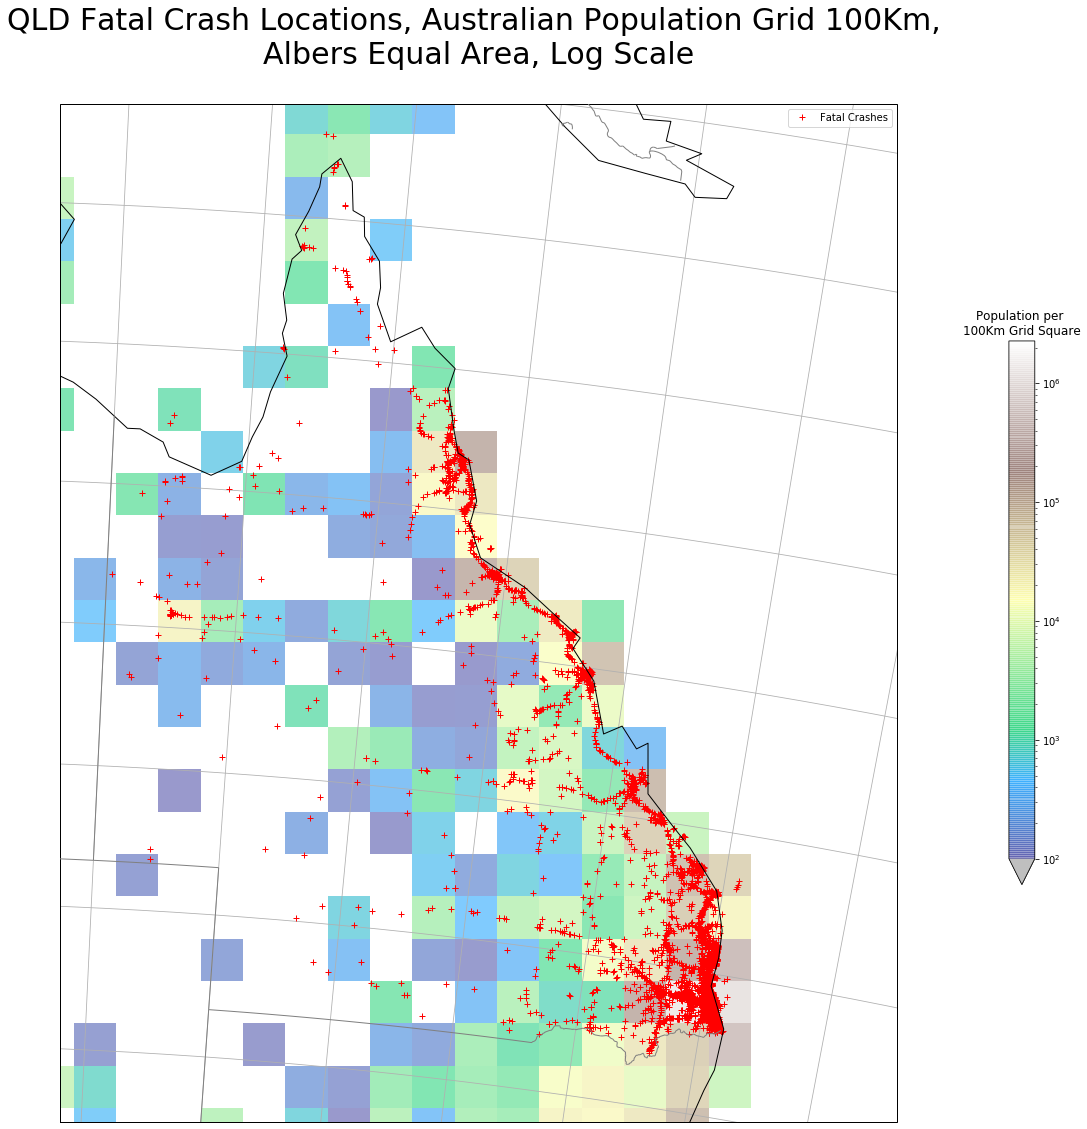

In [173]:
fig, ax = draw_queensland(projection=albo)

my_cmap = plt.cm.get_cmap('terrain')
my_cmap.set_under('grey', alpha=0.0)

# because we are truncating the data array to show, we must recompute the
# map extent it covers
down_scale_factor = 100

# original x and y step (we know it is = 1km, but get value from GEOTIF object for generality)
x_step = gt[1]
y_step = gt[5]

data3_ext = [
    extent_tif[0],
    extent_tif[0]
    + x_step * data3.shape[1] * down_scale_factor,
    extent_tif[3]
    + (y_step) * data3.shape[0] * down_scale_factor,
    extent_tif[3],
]

pcm = plt.imshow(
    data3,
    extent=data3_ext,
    transform=albo,
    cmap=my_cmap,
    norm=colors.LogNorm(),
    zorder=1,
    alpha=0.5,
    vmin=100,
)


# plot fatal crashes
ax.plot(
    albo_xy[:, 0],
    albo_xy[:, 1],
    'r+',
    label='Fatal Crashes',
)


cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)
cbar.ax.set_title('Population per \n100Km Grid Square')

plt.title(
    'QLD Fatal Crash Locations, Australian Population Grid 100Km, \nAlbers Equal Area, Log Scale',
    {'fontsize': 30},
    pad=40,
)

ax.legend()

plt.show()

------
We can repeat the mapping for our medium population grid, but it dosen't add much to the understanding

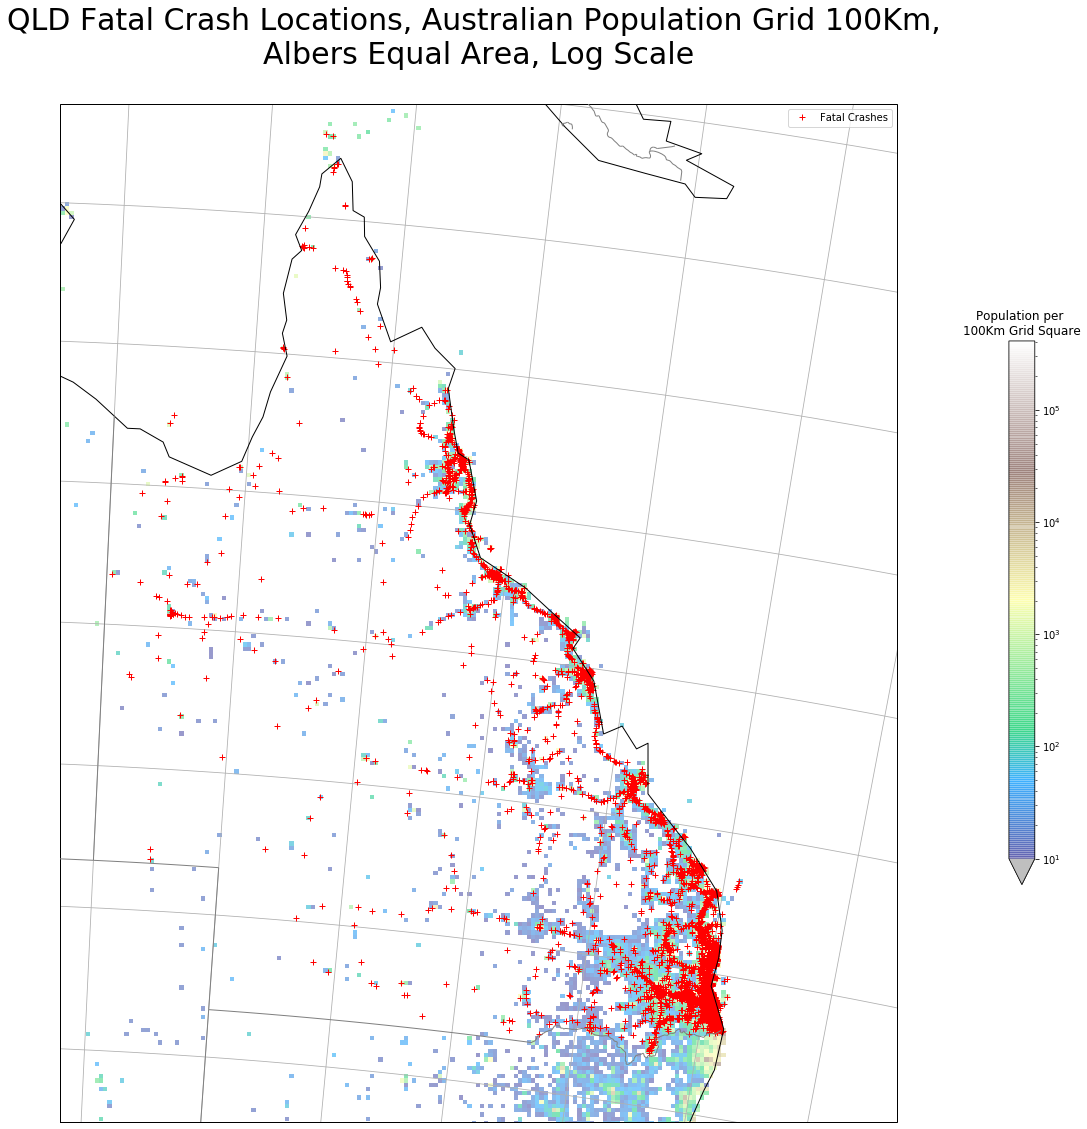

In [174]:
fig, ax = draw_queensland(projection=albo)

my_cmap = plt.cm.get_cmap('terrain')
my_cmap.set_under('grey', alpha=0.0)

# because we are truncating the data array to show, we must recompute the
# map extent it covers
down_scale_factor = 100

# original x and y step (we know it is = 1km, but get value from GEOTIF object for generality)
x_step = gt[1]
y_step = gt[5]

data4_ext = [
    extent_tif[0],
    extent_tif[0]
    + x_step * data3.shape[1] * down_scale_factor,
    extent_tif[3]
    + (y_step) * data3.shape[0] * down_scale_factor,
    extent_tif[3],
]

pcm = plt.imshow(
    data4,
    extent=data4_ext,
    transform=albo,
    cmap=my_cmap,
    norm=colors.LogNorm(),
    zorder=1,
    alpha=0.5,
    vmin=10,
)


# plot fatal crashes
ax.plot(
    albo_xy[:, 0],
    albo_xy[:, 1],
    'r+',
    label='Fatal Crashes',
)


cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)
cbar.ax.set_title('Population per \n100Km Grid Square')

plt.title(
    'QLD Fatal Crash Locations, Australian Population Grid 100Km, \nAlbers Equal Area, Log Scale',
    {'fontsize': 30},
    pad=40,
)

ax.legend()

plt.show()


-----
## Fatal Crash Density

We can count the fatal crashes within each grid square of our coarse grid, to give us crash density.  Note increasing row number runs south

In [175]:
data3_ext

[-3853000.0, 2447000.0, -4814000.0, -1014000.0]

In [176]:
crash_rate = np.zeros(data3.shape)

# get the fatal crashes per 100 km grid square
for x, y in zip(albo_xy[:, 0], albo_xy[:, 1]):
    row = 37 - int(
        (y - data3_ext[2]) // (down_scale_factor * 1000)
    )
    col = int(
        (x - data3_ext[0]) // (down_scale_factor * 1000)
    )
    crash_rate[row, col] = crash_rate[row, col] + 1
# end for

In [177]:
data3.shape, down_scale_factor

((38, 63), 100)

----
### Plot the Crash Density



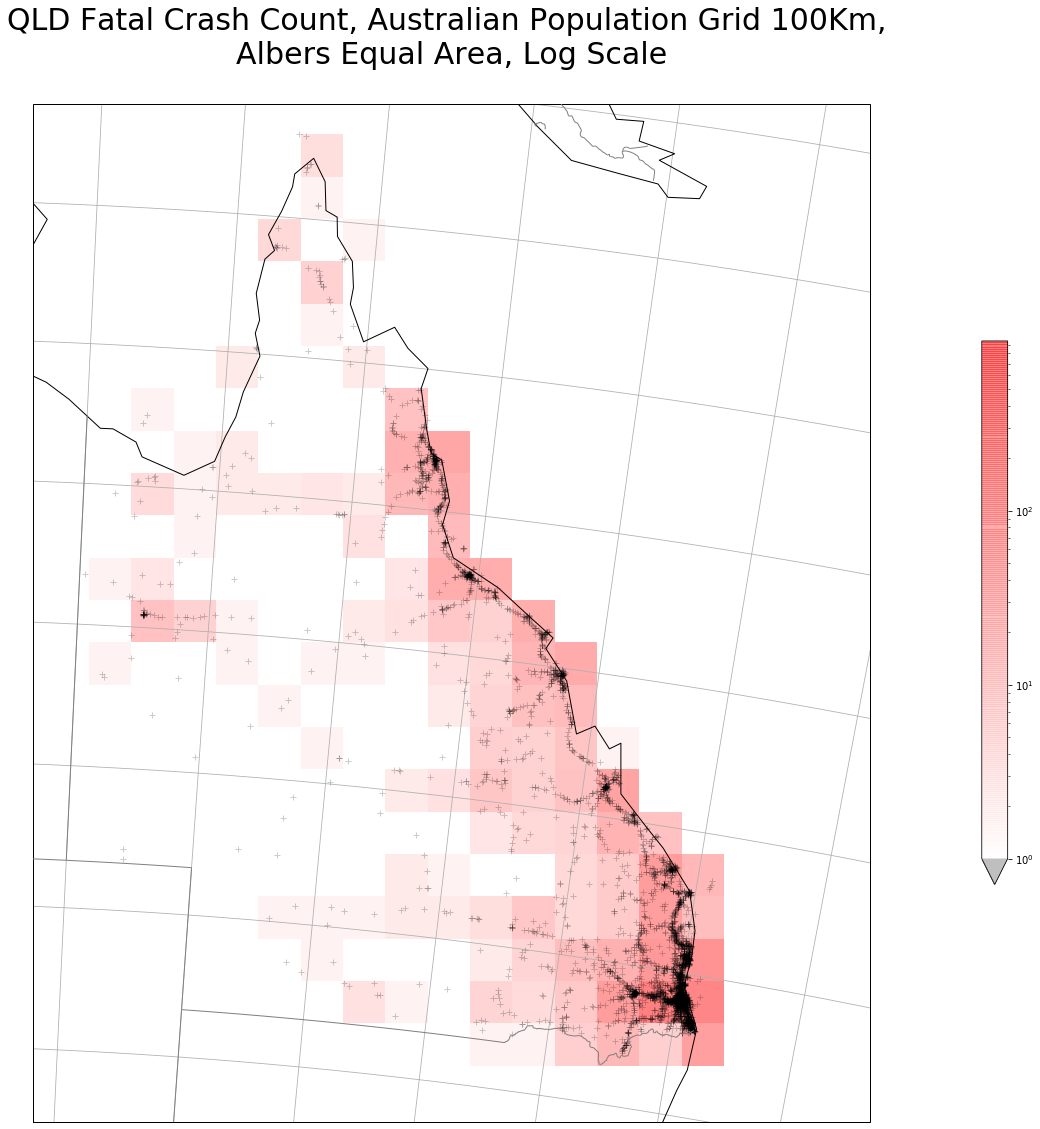

In [178]:
fig, ax = draw_queensland(projection=albo)

my_cmap = colors.LinearSegmentedColormap.from_list(
    'mycmap', ['white', 'red']
)
my_cmap.set_under('grey', alpha=0.0)

# because we are truncating the data array to show, we must recompute the
# map extent it covers
down_scale_factor = 100

# original x and y step (we know it is = 1km, but get value from GEOTIF object for generality)
x_step = gt[1]
y_step = gt[5]

data3_ext = [
    extent_tif[0],
    extent_tif[0]
    + x_step * data3.shape[1] * down_scale_factor,
    extent_tif[3]
    + (y_step) * data3.shape[0] * down_scale_factor,
    extent_tif[3],
]

pcm = plt.imshow(
    crash_rate,
    extent=data3_ext,
    transform=albo,
    cmap=my_cmap,
    norm=colors.LogNorm(),
    zorder=1,
    alpha=0.5,
    vmin=1,
)


# plot fatal crashes
ax.plot(albo_xy[:, 0], albo_xy[:, 1], 'k+', alpha=0.2)


cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)

plt.title(
    'QLD Fatal Crash Count, Australian Population Grid 100Km, \nAlbers Equal Area, Log Scale',
    {'fontsize': 30},
    pad=40,
)


plt.show()

The crash density hugs the coast as we expect.  The crash density in Cape York is a little puzzling

----
## Crash Rate per Capita

So now we will get the crash rate per person for each coarse grid square.  Because there are so many grid squares with no population, we have to check for this

In [179]:
crash_rate_pc = np.zeros(data3.shape)

for row in range(data3.shape[0]):
    for col in range(data3.shape[1]):
        if data3[row, col] == 0:
            crash_rate_pc[row, col] = 0
        else:
            crash_rate_pc[row, col] = (
                crash_rate[row, col] / data3[row, col]
            )
        # end if

    # end for
# end for

Get the maximum crash rate per person

In [180]:
np.max(np.max(crash_rate_pc))

0.39089221905003857

-----
## Final Visualization

We get a partially surprising (to me) result.  It is well known that outback country roads have a higher crash rate than could be expected by population density (people driving on unfamiliar roads, poorly maintained roads, driving tired on long trips, driving with stock on the road), but I didn't expect Cape York to be so bad.  Birdsville maybe I can guess the reasons for (Birdsville Races draws huge crowds with high alcohol consumption).   Maybe Cape York being so remote means that the long time-to-hospital cause more crashes to be fatal.  

It might be an interesting sociology / data science project to take up.


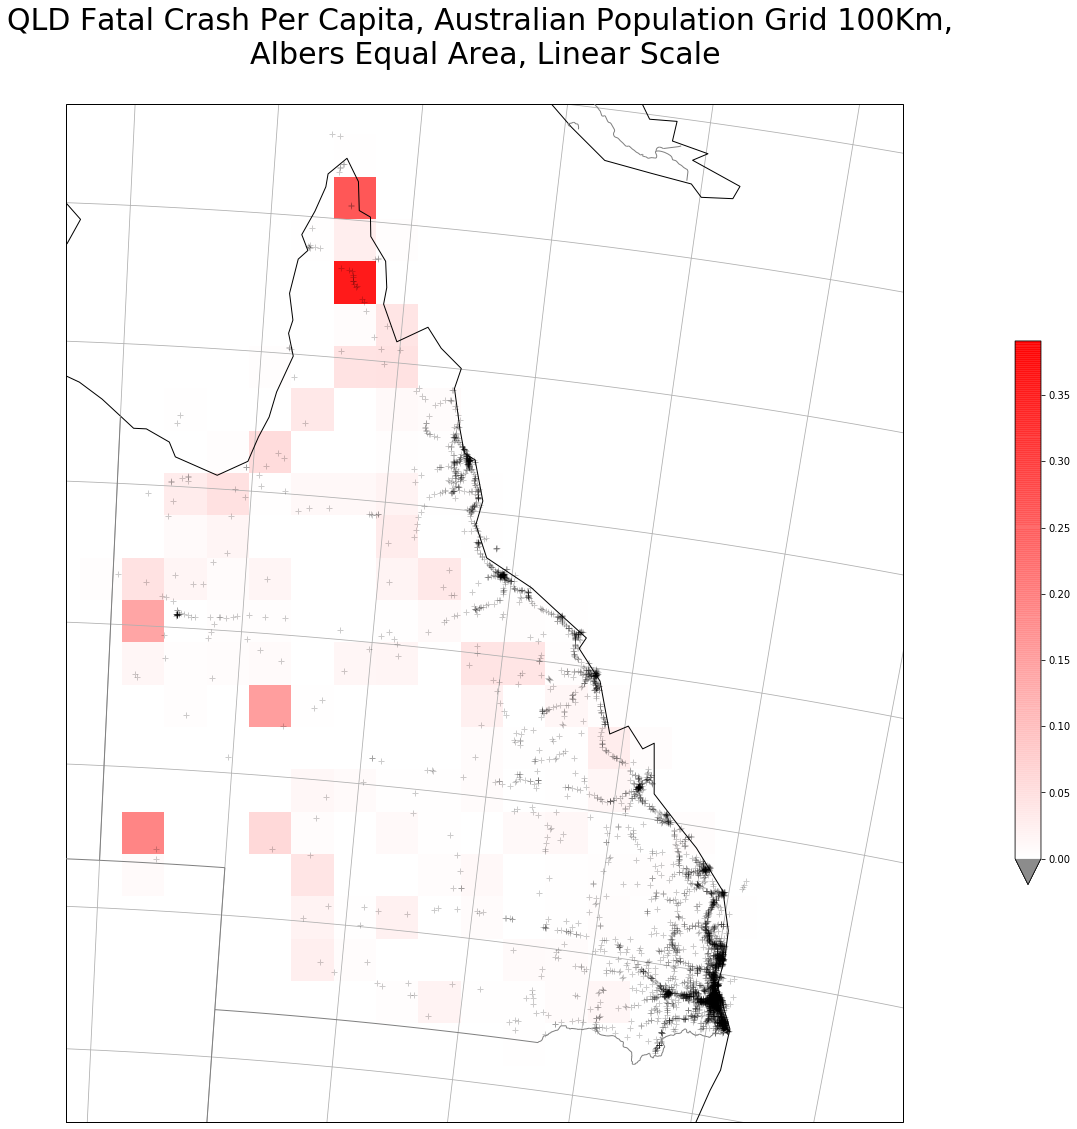

In [181]:
fig, ax = draw_queensland(projection=albo)


my_cmap = colors.LinearSegmentedColormap.from_list(
    'mycmap', ['white', 'red']
)
my_cmap.set_under('grey', alpha=0.0)

# because we are truncating the data array to show, we must recompute the
# map extent it covers
down_scale_factor = 100

# original x and y step (we know it is = 1km, but get value from GEOTIF object for generality)
x_step = gt[1]
y_step = gt[5]

data3_ext = [
    extent_tif[0],
    extent_tif[0]
    + x_step * data3.shape[1] * down_scale_factor,
    extent_tif[3]
    + (y_step) * data3.shape[0] * down_scale_factor,
    extent_tif[3],
]

pcm = plt.imshow(
    crash_rate_pc,
    extent=data3_ext,
    transform=albo,
    cmap=my_cmap,
    # norm=colors.LogNorm(),
    zorder=1,
    alpha=0.9,
    vmin=0,
)


# plot fatal crashes
ax.plot(albo_xy[:, 0], albo_xy[:, 1], 'k+', alpha=0.2)


cbar = fig.colorbar(
    pcm, ax=ax, shrink=0.5, pad=0.1, extend='min'
)

plt.title(
    'QLD Fatal Crash Per Capita, Australian Population Grid 100Km, \nAlbers Equal Area, Linear Scale',
    {'fontsize': 30},
    pad=40,
)

plt.show()

-----
## Statistical Analysis

I thought I would test my perception that population density and fatal crash density were correlated

Create two arrays for non-zero population and crash density data pairs, and do a quick-and-dirty plot

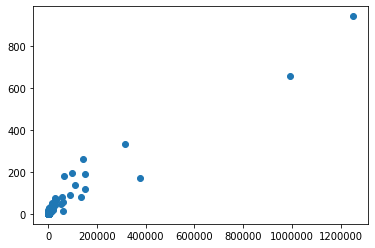

In [182]:
density = []
crashs = []
for row in range(data3.shape[0]):
    for col in range(data3.shape[1]):
        if (crash_rate[row, col] > 0) and (
            data3[row, col] > 0
        ):
            density.append(data3[row, col])
            crashs.append(crash_rate[row, col])
        # end if
    # end for
# end for

_ = plt.plot(density, crashs, 'o')

-----
Do a less quick and dirty plot

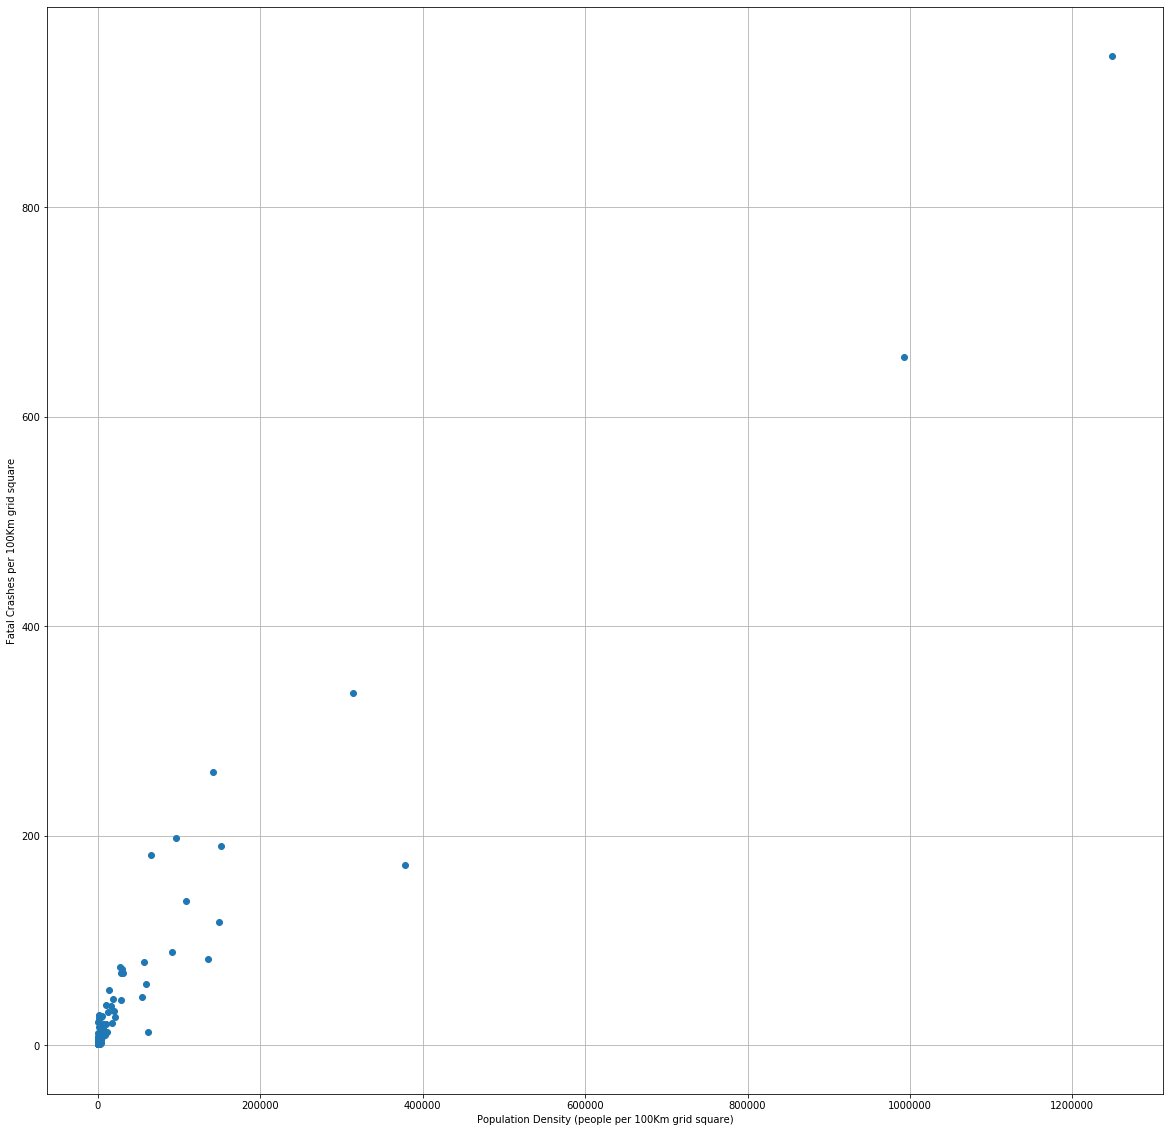

In [183]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)


# ax.loglog()
ax.grid(axis='both')
ax.set_xlabel(
    'Population Density (people per 100Km grid square)'
)
ax.set_ylabel('Fatal Crashes per 100Km grid square')

ax.plot(density, crashs, 'o')

----
Do the same plot but with log-log scales

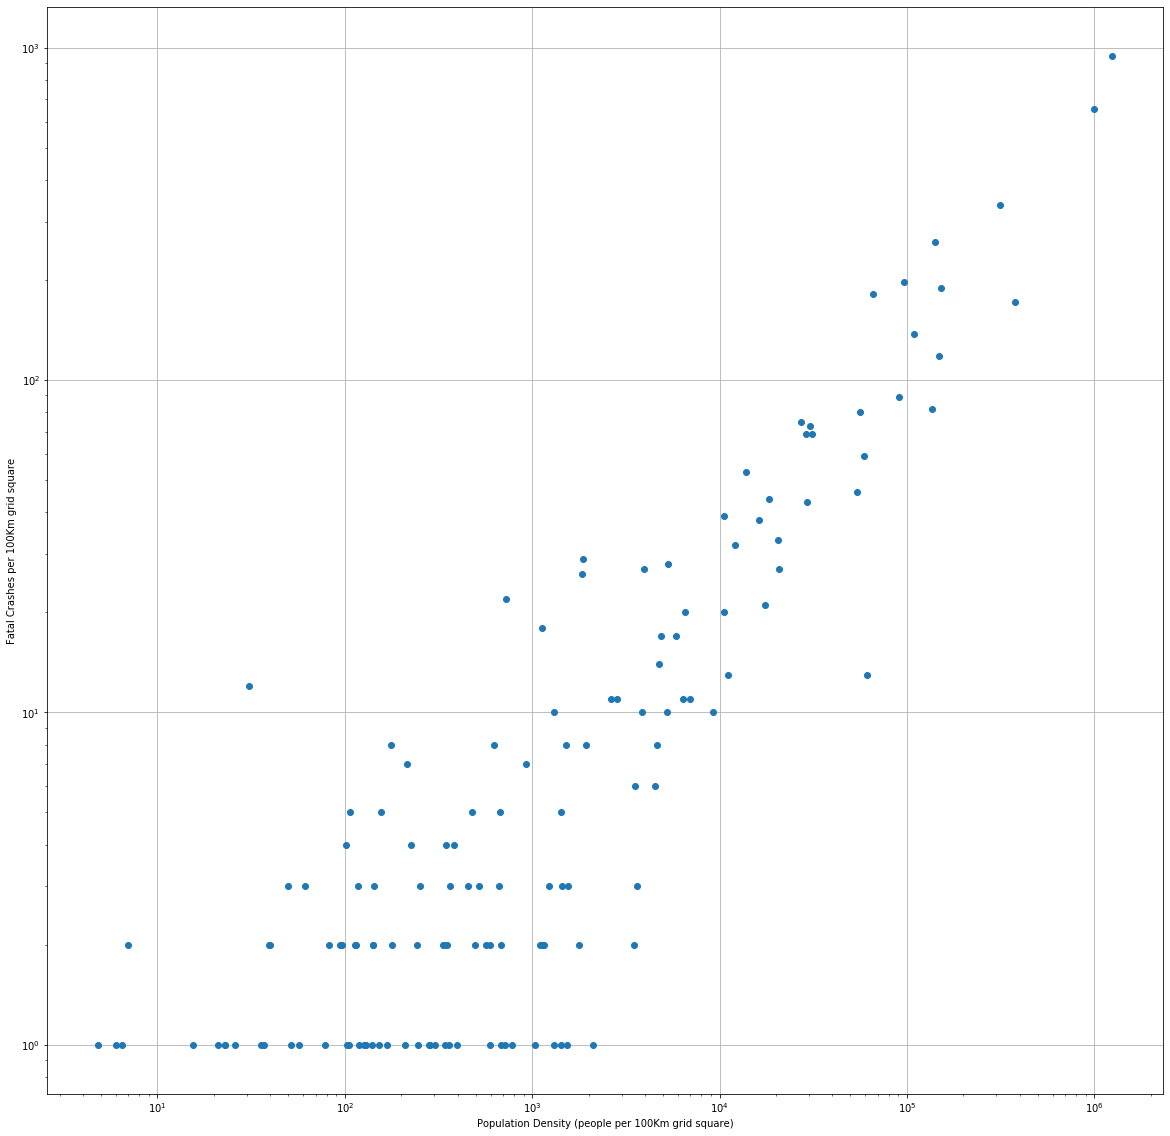

In [184]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)


ax.loglog()
ax.grid(axis='both')
ax.set_xlabel(
    'Population Density (people per 100Km grid square)'
)
ax.set_ylabel('Fatal Crashes per 100Km grid square')

ax.plot(density, crashs, 'o')

----
### Visualize with Seaborn

We use Seaborn to visualize the linear relation between population and crash density

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


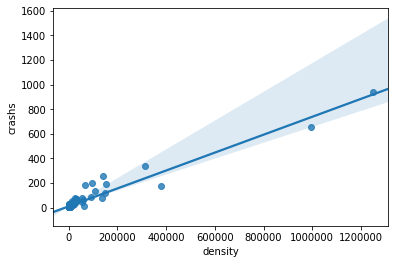

In [185]:
import seaborn as sns

df_dict = {'density': (density), 'crashs': (crashs)}
df = pd.DataFrame(df_dict)

sns.regplot('density', 'crashs', data=df)

Visualize via Seaborn the log-log relationship

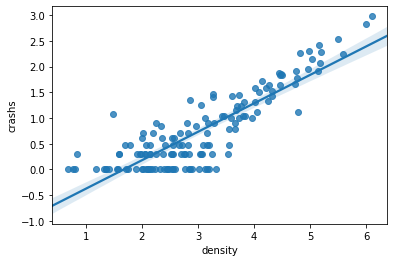

In [186]:
df_dict = {
    'density': np.log10(density),
    'crashs': np.log10(crashs),
}
df = pd.DataFrame(df_dict)

sns.regplot('density', 'crashs', data=df)

-----
## Linear Regression

We use OLS to find that the relation between population and crash density is unlikely to have been observed by chance

In [187]:
from statsmodels.formula.api import ols

df_dict = {'density': density, 'crashs': crashs}
df = pd.DataFrame(df_dict)

res1 = ols('crashs ~ density', data=df).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 crashs   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1946.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.18e-84
Time:                        20:03:12   Log-Likelihood:                -676.10
No. Observations:                 143   AIC:                             1356.
Df Residuals:                     141   BIC:                             1362.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1650      2.363      4.302      0.000       5.494      14.836
density        0.0007   1.65e-05     44.110      0.000       0.001       0.001
==============================================================================
Omnibus:                       96.913   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1035.411
Skew:                           2.192   Prob(JB):                    1.46e-225
Kurtosis:                      15.432   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

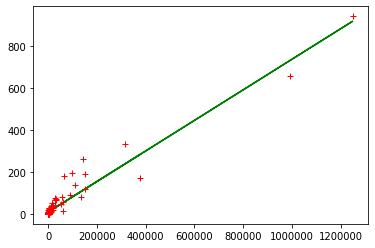

In [188]:
_ = plt.plot(df['density'], res1.predict(), 'g-')
_ = plt.plot(df['density'], df['crashs'], 'r+')

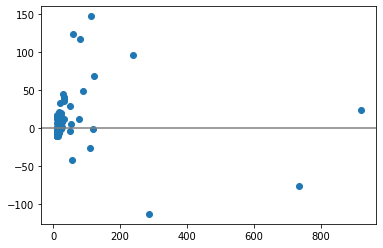

In [189]:
_ = plt.plot(res1.predict(), res1.resid, 'o')
_ = plt.axhline(0, color='gray')

---------------
## Crash Rate

Finally we look at the crash rate per capita, as a function of population density

I think the results are inconclusive, but maybe as density goes up, and you are more likely to be close to a hospital, fatal crashes per person decreases.


In [190]:
rate_pc = [a / b for a, b in zip(crashs, density)]

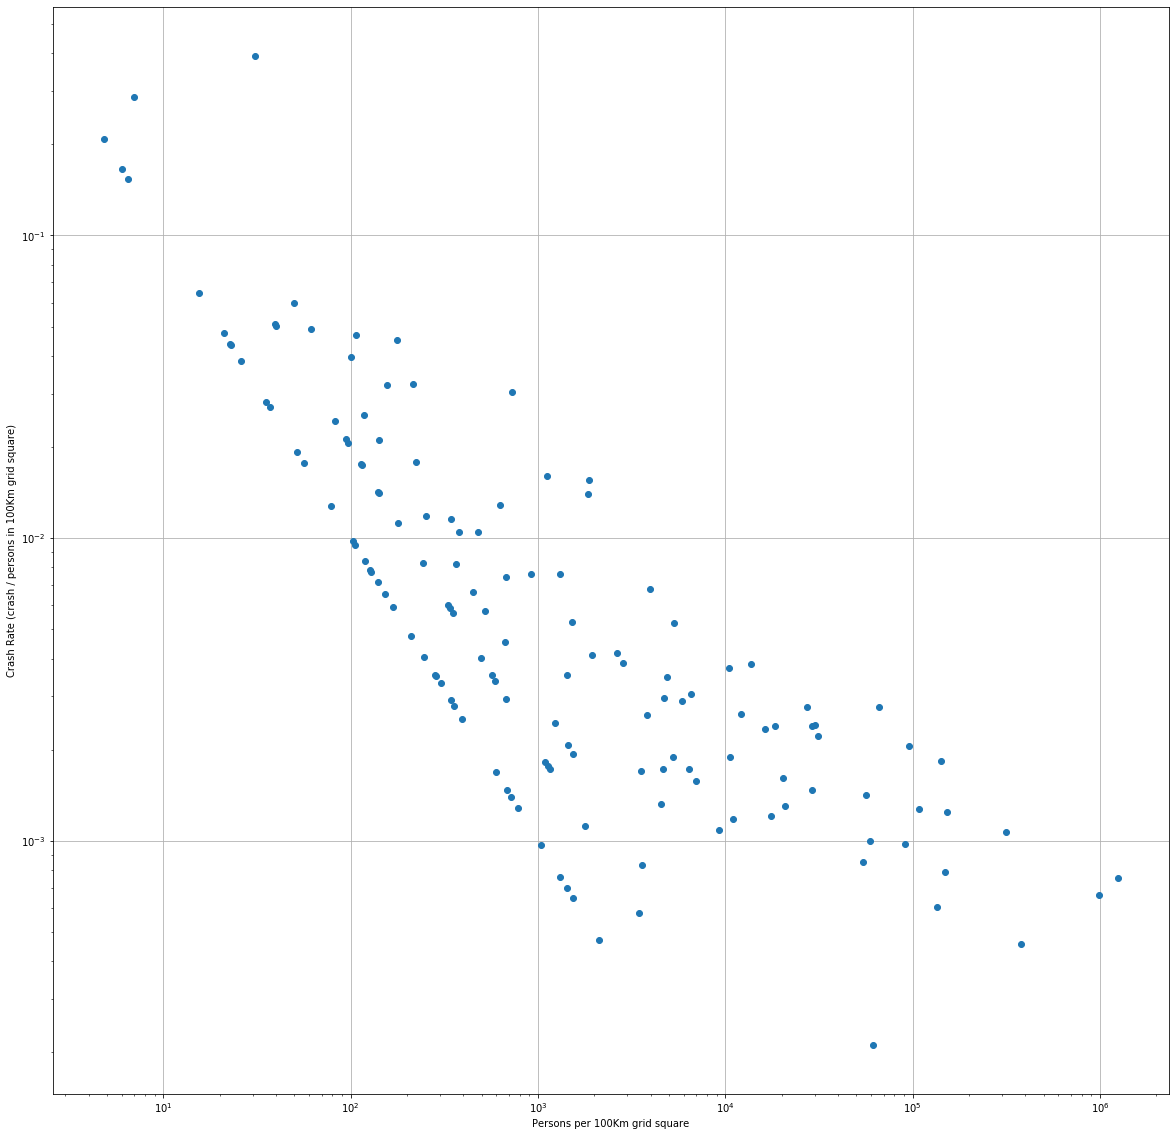

In [191]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)


ax.loglog()
ax.grid(axis='both')
ax.set_ylabel(
    'Crash Rate (crash / persons in 100Km grid square)'
)
ax.set_xlabel('Persons per 100Km grid square')

ax.plot(density, rate_pc, 'o')

## Conclusions / Summary

Some interesting and thought provoking findings can be discovered by poking around in, and combining, public datasets.

-------------------
## Reproducibility

### Notebook version status

In [192]:
theNotebook = '2020-06-10-dc-RoadCrashes2.ipynb'

In [193]:
# show info to support reproducibility


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())


print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print(
    'Notebook run at: '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at: '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on: ' + platform.platform())

python version : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\RoadCrashes2NotebookProject\develop
Notebook name: 2020-06-10-dc-RoadCrashes2.ipynb
Notebook run at: 2020-06-21 20:03:34.908312 local time
Notebook run at: 2020-06-21 10:03:34.909315 UTC
Notebook run on: Windows-10-10.0.18362-SP0


In [194]:
%watermark

2020-06-21T20:03:34+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [195]:
%watermark -h -iv

pandas     1.0.0
matplotlib 3.1.1
osgeo.gdal 2.3.3
cartopy    0.17.0
numpy      1.15.4
geopandas  0.5.1
osgeo      2.3.3
platform   1.0.8
seaborn    0.9.0
host name: DESKTOP-SODFUN6
